# Spirality Analysis: Cartesian vs Polar Coupling

This notebook performs a systematic comparison of spiral pattern formation between:
- **Polar Coupling**: Periodic boundary in angular direction
- **Cartesian Coupling**: No periodic boundaries

We sweep across:
- Coupling strength K: [0, 1] in steps of 0.1
- Noise scale: [0, 1] in steps of 0.1
- Multiple random seeds for statistical robustness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import time

from kuramoto_models import (
    setup_euclidean_grid,
    compute_coupling_cartesian,
    compute_coupling_polar,
    run_kuramoto_simulation,
    compute_spiral_index
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Define Parameter Space

In [6]:
# Grid parameters (fixed)
N_euclidean = 50
r_max = 1.0
r_coupling = 0.4
p_coupling = 0.25
omega_mean = 5.0
omega_std = 0.5

# Polar coupling parameters
theta_scale = 0.5
r_scale = 1.0
Lx = 2 * np.pi

# Time parameters
dt = 0.01
T_total = 50.0
save_interval = 25

# Parameter sweep ranges
K_values = np.arange(0, 4, 0.4)  # [0, 0.1, 0.2, ..., 1.0]
noise_values = np.arange(0, 30, 3)  # [0, 0.1, 0.2, ..., 1.0]
seeds = np.arange(10, 20)  # 10 different seeds

print(f"Parameter sweep:")
print(f"  K values: {len(K_values)} values from {K_values.min():.1f} to {K_values.max():.1f}")
print(f"  Noise values: {len(noise_values)} values from {noise_values.min():.1f} to {noise_values.max():.1f}")
print(f"  Seeds: {len(seeds)} random seeds")
print(f"  Total simulations: {len(K_values) * len(noise_values) * len(seeds) * 2} (polar + cartesian)")
print(f"  Estimated time: ~{len(K_values) * len(noise_values) * len(seeds) * 2 * 10 / 60:.1f} minutes")

Parameter sweep:
  K values: 10 values from 0.0 to 3.6
  Noise values: 10 values from 0.0 to 27.0
  Seeds: 10 random seeds
  Total simulations: 2000 (polar + cartesian)
  Estimated time: ~333.3 minutes


## 2. Setup Grid (Shared)

In [7]:
# Create grid once
x_points, y_points, theta_points, r_points, mask, X_grid, Y_grid = \
    setup_euclidean_grid(N_euclidean, r_max)

n_points = len(x_points)
print(f"Grid setup complete: {n_points} points")

Grid created: 1876 points within radius 1.0
Grid setup complete: 1876 points


## 4. Run Parameter Sweep

In [8]:
# Compute Coupling Matrices (Once)
# Store coupling matrices for each seed
# (coupling depends on random link formation, so differs per seed)
print("Computing coupling matrices for all seeds...")
coupling_polar_dict = {}
coupling_cart_dict = {}

for seed in seeds:
    # Polar coupling
    np.random.seed(seed)
    coupling_polar_dict[seed] = compute_coupling_polar(
        theta_points, r_points, r_coupling, p_coupling,
        theta_scale, r_scale, Lx
    )
    
    # Cartesian coupling
    np.random.seed(seed)
    coupling_cart_dict[seed] = compute_coupling_cartesian(
        x_points, y_points, r_coupling, p_coupling
    )

print(f"Coupling matrices computed for {len(seeds)} seeds.")




# Initialize storage arrays
spirality_polar = np.zeros((len(K_values), len(noise_values), len(seeds)))
spirality_cart = np.zeros((len(K_values), len(noise_values), len(seeds)))

# Start timer
start_time = time.time()

# Nested loops with progress bar
total_iterations = len(K_values) * len(noise_values) * len(seeds)
pbar = tqdm(total=total_iterations, desc="Running simulations")

for i, K in enumerate(K_values):
    for j, noise_scale in enumerate(noise_values):
        for k, seed in enumerate(seeds):
            
            # Initialize natural frequencies
            np.random.seed(seed)
            omega = omega_mean + omega_std * np.random.randn(n_points)
            
            # ===== POLAR COUPLING =====
            # Use pre-computed coupling matrix
            coupling_polar = coupling_polar_dict[seed]
            
            phase_history_polar, _ = run_kuramoto_simulation(
                coupling_polar, omega, dt, T_total, save_interval,
                K, noise_scale, seed, verbose=False
            )
            
            # Compute spirality of final frame
            final_phase_polar = phase_history_polar[:, -1]
            spirality_polar[i, j, k] = compute_spiral_index(
                x_points, y_points, final_phase_polar, center=(0, 0), direction=1
            )
            # Check clockwise too
            spirality_cw = compute_spiral_index(
                x_points, y_points, final_phase_polar, center=(0, 0), direction=-1
            )
            spirality_polar[i, j, k] = max(spirality_polar[i, j, k], spirality_cw)
            
            # ===== CARTESIAN COUPLING =====
            # Use pre-computed coupling matrix
            coupling_cart = coupling_cart_dict[seed]
            
            phase_history_cart, _ = run_kuramoto_simulation(
                coupling_cart, omega, dt, T_total, save_interval,
                K, noise_scale, seed, verbose=False
            )
            
            # Compute spirality of final frame
            final_phase_cart = phase_history_cart[:, -1]
            spirality_cart[i, j, k] = compute_spiral_index(
                x_points, y_points, final_phase_cart, center=(0, 0), direction=1
            )
            # Check clockwise too
            spirality_cw = compute_spiral_index(
                x_points, y_points, final_phase_cart, center=(0, 0), direction=-1
            )
            spirality_cart[i, j, k] = max(spirality_cart[i, j, k], spirality_cw)
            
            pbar.update(1)

pbar.close()
elapsed = time.time() - start_time
print(f"\nSimulations complete! Total time: {elapsed/60:.1f} minutes")

Computing coupling matrices for all seeds...
Computing coupling matrix (Polar distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 140171 total connections
Average connections per oscillator: 74.7
Computing coupling matrix (Cartesian distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 114219 total connections
Average connections per oscillator: 60.9
Computing coupling matrix (Polar distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 140782 total connections
Average connections per oscillator: 75.0
Computing coupling matrix (Cartesian distances)...
  Processed 500/1876 points
  Processed 1000/1876 points
  Processed 1500/1876 points
Coupling computed: 114078 total connections
Average connections per oscillator: 60.8
Computing coupling matrix (Polar distances)...
  Processed 500/1876 points


Running simulations: 100%|█████████████████████████████████████████████████████████| 1000/1000 [50:43<00:00,  3.04s/it]


Simulations complete! Total time: 50.7 minutes


## 5. Compute Statistics

In [9]:
# Average across seeds
spirality_polar_mean = np.mean(spirality_polar, axis=2)
spirality_cart_mean = np.mean(spirality_cart, axis=2)

# Standard error across seeds
spirality_polar_sem = np.std(spirality_polar, axis=2) / np.sqrt(len(seeds))
spirality_cart_sem = np.std(spirality_cart, axis=2) / np.sqrt(len(seeds))

# Difference (Polar - Cartesian)
spirality_diff = spirality_polar_mean - spirality_cart_mean

print(f"Spirality statistics:")
print(f"  Polar - Mean: {spirality_polar_mean.mean():.3f}, Range: [{spirality_polar_mean.min():.3f}, {spirality_polar_mean.max():.3f}]")
print(f"  Cartesian - Mean: {spirality_cart_mean.mean():.3f}, Range: [{spirality_cart_mean.min():.3f}, {spirality_cart_mean.max():.3f}]")
print(f"  Difference - Mean: {spirality_diff.mean():.3f}, Range: [{spirality_diff.min():.3f}, {spirality_diff.max():.3f}]")

Spirality statistics:
  Polar - Mean: 0.127, Range: [0.022, 0.270]
  Cartesian - Mean: 0.101, Range: [0.022, 0.325]
  Difference - Mean: 0.025, Range: [-0.106, 0.183]


## 6. Statistical Significance Testing

In [10]:
# Paired t-test for each (K, noise) combination
p_values = np.zeros((len(K_values), len(noise_values)))
t_statistics = np.zeros((len(K_values), len(noise_values)))

for i in range(len(K_values)):
    for j in range(len(noise_values)):
        # Paired t-test: same seed for both models
        t_stat, p_val = stats.ttest_rel(
            spirality_polar[i, j, :],
            spirality_cart[i, j, :]
        )
        t_statistics[i, j] = t_stat
        p_values[i, j] = p_val

# Multiple comparison correction (Bonferroni)
n_comparisons = len(K_values) * len(noise_values)
alpha = 0.05
bonferroni_threshold = alpha / n_comparisons

significant_mask = p_values < bonferroni_threshold
n_significant = np.sum(significant_mask)

print(f"Statistical significance:")
print(f"  Total comparisons: {n_comparisons}")
print(f"  Bonferroni-corrected alpha: {bonferroni_threshold:.5f}")
print(f"  Significant differences: {n_significant} ({100*n_significant/n_comparisons:.1f}%)")
print(f"  Mean p-value: {p_values.mean():.4f}")
print(f"  Median p-value: {np.median(p_values):.4f}")

Statistical significance:
  Total comparisons: 100
  Bonferroni-corrected alpha: 0.00050
  Significant differences: 0 (0.0%)
  Mean p-value: nan
  Median p-value: nan


## 7. Visualization: Heatmaps

C:\Users\Steinmetz lab\AppData\Local\Temp\ipykernel_48780\1879480060.py:68: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Steinmetz lab\AppData\Local\Temp\ipykernel_48780\1879480060.py:68: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
E:\anaconda3\envs\spiralSim\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
E:\anaconda3\envs\spiralSim\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


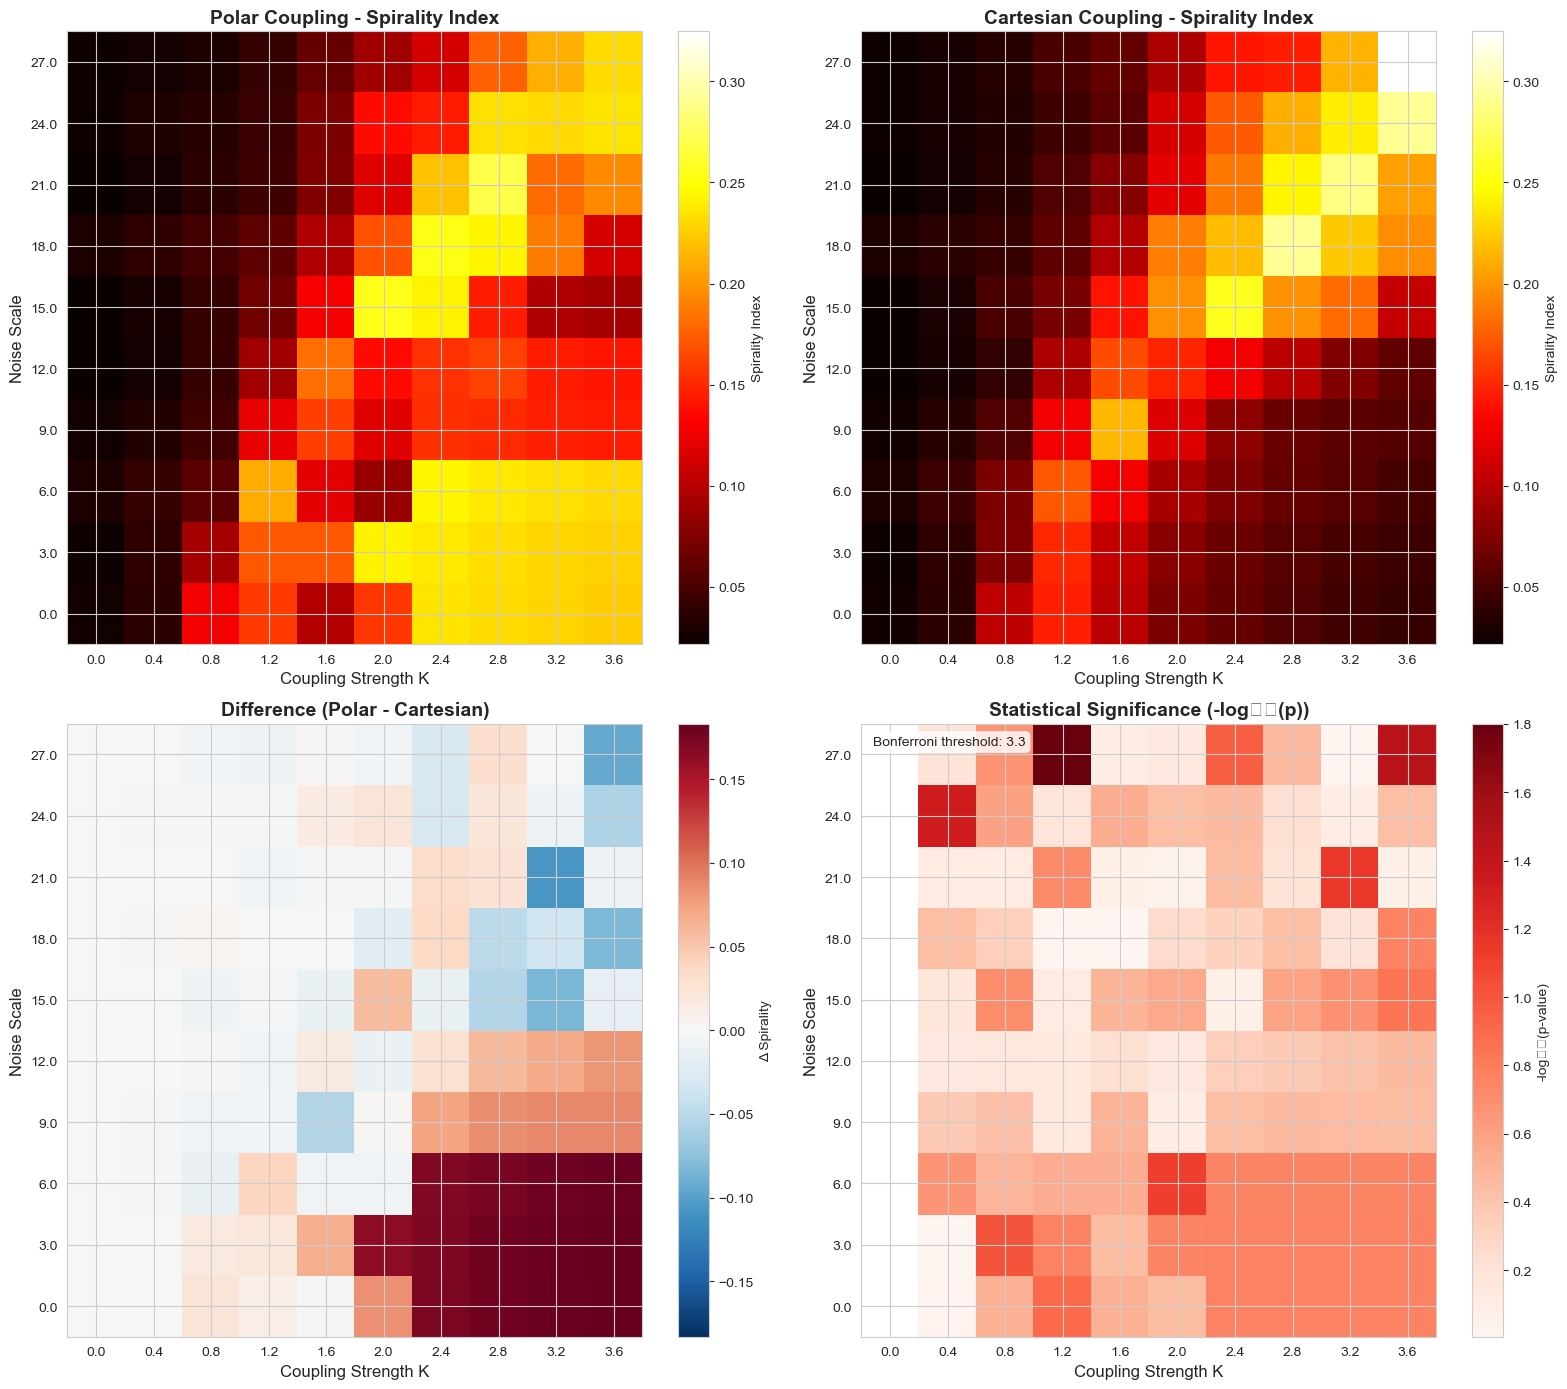

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Common colormap settings
vmin_spiral = min(spirality_polar_mean.min(), spirality_cart_mean.min())
vmax_spiral = max(spirality_polar_mean.max(), spirality_cart_mean.max())

# 1. Polar Coupling Spirality
im1 = axes[0, 0].imshow(spirality_polar_mean.T, origin='lower', cmap='hot',
                        vmin=vmin_spiral, vmax=vmax_spiral, aspect='auto')
axes[0, 0].set_xlabel('Coupling Strength K', fontsize=12)
axes[0, 0].set_ylabel('Noise Scale', fontsize=12)
axes[0, 0].set_title('Polar Coupling - Spirality Index', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(range(len(K_values)))
axes[0, 0].set_xticklabels([f'{v:.1f}' for v in K_values])
axes[0, 0].set_yticks(range(len(noise_values)))
axes[0, 0].set_yticklabels([f'{v:.1f}' for v in noise_values])
plt.colorbar(im1, ax=axes[0, 0], label='Spirality Index')

# 2. Cartesian Coupling Spirality
im2 = axes[0, 1].imshow(spirality_cart_mean.T, origin='lower', cmap='hot',
                        vmin=vmin_spiral, vmax=vmax_spiral, aspect='auto')
axes[0, 1].set_xlabel('Coupling Strength K', fontsize=12)
axes[0, 1].set_ylabel('Noise Scale', fontsize=12)
axes[0, 1].set_title('Cartesian Coupling - Spirality Index', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(len(K_values)))
axes[0, 1].set_xticklabels([f'{v:.1f}' for v in K_values])
axes[0, 1].set_yticks(range(len(noise_values)))
axes[0, 1].set_yticklabels([f'{v:.1f}' for v in noise_values])
plt.colorbar(im2, ax=axes[0, 1], label='Spirality Index')

# 3. Difference (Polar - Cartesian)
diff_max = max(abs(spirality_diff.min()), abs(spirality_diff.max()))
im3 = axes[1, 0].imshow(spirality_diff.T, origin='lower', cmap='RdBu_r',
                        vmin=-diff_max, vmax=diff_max, aspect='auto')
axes[1, 0].set_xlabel('Coupling Strength K', fontsize=12)
axes[1, 0].set_ylabel('Noise Scale', fontsize=12)
axes[1, 0].set_title('Difference (Polar - Cartesian)', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(K_values)))
axes[1, 0].set_xticklabels([f'{v:.1f}' for v in K_values])
axes[1, 0].set_yticks(range(len(noise_values)))
axes[1, 0].set_yticklabels([f'{v:.1f}' for v in noise_values])
plt.colorbar(im3, ax=axes[1, 0], label='Δ Spirality')

# Add significance markers (need to transpose coordinates)
for i in range(len(K_values)):
    for j in range(len(noise_values)):
        if significant_mask[i, j]:
            axes[1, 0].plot(i, j, 'k*', markersize=10, markeredgewidth=1, markeredgecolor='white')

# 4. Statistical Significance (-log10(p-value))
log_p = -np.log10(p_values + 1e-300)  # Add small constant to avoid log(0)
im4 = axes[1, 1].imshow(log_p.T, origin='lower', cmap='Reds', aspect='auto')
axes[1, 1].set_xlabel('Coupling Strength K', fontsize=12)
axes[1, 1].set_ylabel('Noise Scale', fontsize=12)
axes[1, 1].set_title('Statistical Significance (-log₁₀(p))', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(K_values)))
axes[1, 1].set_xticklabels([f'{v:.1f}' for v in K_values])
axes[1, 1].set_yticks(range(len(noise_values)))
axes[1, 1].set_yticklabels([f'{v:.1f}' for v in noise_values])
cbar4 = plt.colorbar(im4, ax=axes[1, 1], label='-log₁₀(p-value)')

# Add significance threshold line
threshold_log = -np.log10(bonferroni_threshold)
axes[1, 1].text(0.02, 0.98, f'Bonferroni threshold: {threshold_log:.1f}',
               transform=axes[1, 1].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Save Results

In [ ]:
# Save data to file
np.savez('spirality_comparison_results.npz',
         spirality_polar=spirality_polar,
         spirality_cart=spirality_cart,
         spirality_polar_mean=spirality_polar_mean,
         spirality_cart_mean=spirality_cart_mean,
         spirality_diff=spirality_diff,
         p_values=p_values,
         t_statistics=t_statistics,
         significant_mask=significant_mask,
         K_values=K_values,
         noise_values=noise_values,
         seeds=seeds)

print("Results saved to 'spirality_comparison_results.npz'")